# Combined trajectory analysis and Markov chain statistics for cell swimming states
This script analyzes per-cell swimming trajectory data to extract state durations, speeds, and transition statistics. It computes and visualizes probability mass functions (PMFs) for state durations and speeds, state occupancy percentages, and Markov transition matrices (including and excluding self-transitions). The script also calculates the mean and standard deviation of these metrics across all cells.

Input:
- input_folder: Directory containing CSV files with swimming state timeseries data (obtained in previous scripts). Use for each cell condition a separate folder.

Output:
- State duration and speed PMF plots (per cell and average)
- Stacked bar plots of state occupancy percentages per cell
- Box/violin plots of mean state durations and speeds
- Markov transition matrices
- Mean and standard deviation of transition probabilities across cells
- DataFrames with per-cell statistics (percentages, durations, speeds)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from scipy.stats import gaussian_kde
from matplotlib.patches import Patch
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D


# Ensure text is saved as editable text in SVG
mpl.rcParams['svg.fonttype'] = 'none'
# Set global font to Arial
mpl.rcParams['font.family'] = 'Arial'

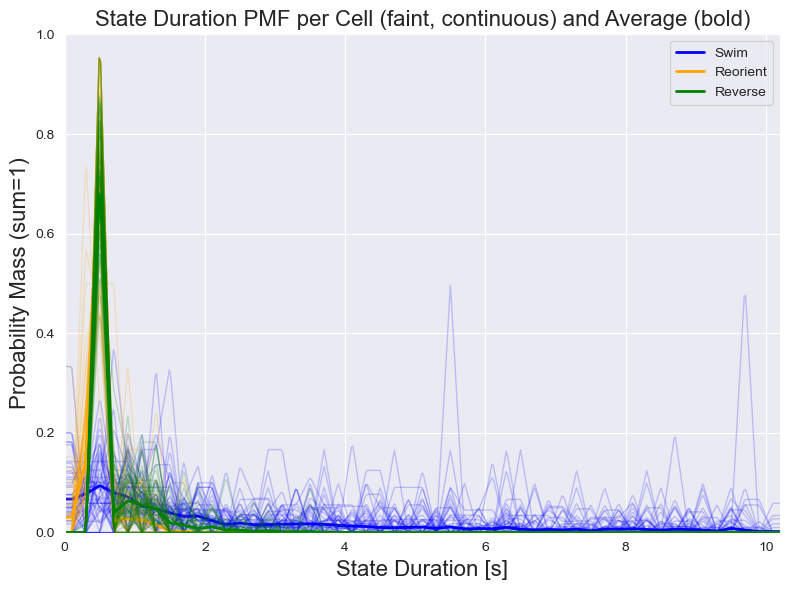

In [6]:
input_folder = 'CONDITION_wt'
csv_files = glob.glob(os.path.join(input_folder, 'STATES_*states_timeseries.csv'))
state_labels = ['Swim', 'Reorient', 'Reverse']
state_col = 'state'
time_col = 'time_sec'
colors = {'Swim': 'blue', 'Reorient': 'orange', 'Reverse': 'green'}

cell_durations = {label: [] for label in state_labels}

for file in csv_files:
    df = pd.read_csv(file)
    state_changes = df[state_col].ne(df[state_col].shift()).cumsum()
    grouped = df.groupby(state_changes)
    durations_per_state = {label: [] for label in state_labels}
    for _, group in grouped:
        state_val = group[state_col].iloc[0]
        if state_val == 0:
            durations_per_state['Swim'].append(group[time_col].iloc[-1] - group[time_col].iloc[0])
        elif state_val == 1:
            durations_per_state['Reorient'].append(group[time_col].iloc[-1] - group[time_col].iloc[0])
        elif state_val == 2:
            durations_per_state['Reverse'].append(group[time_col].iloc[-1] - group[time_col].iloc[0])
    for label in state_labels:
        cell_durations[label].append(durations_per_state[label])

duration_bin_size = 0.2
duration_bins = np.arange(0, 10.1 + duration_bin_size, duration_bin_size)
bin_centers = (duration_bins[:-1] + duration_bins[1:]) / 2
x_fine = np.linspace(duration_bins[0], duration_bins[-1], 500)  # Fine grid for smooth line

plt.figure(figsize=(8, 6))
for label in state_labels:
    # Faint interpolated PMF for each cell
    for durations in cell_durations[label]:
        arr = np.array(durations)
        arr = arr[np.isfinite(arr)]
        if len(arr) > 0:
            counts, _ = np.histogram(arr, bins=duration_bins)
            pmf = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(counts)
            # Interpolate PMF to fine grid
            pmf_interp = np.interp(x_fine, bin_centers, pmf)
            plt.plot(x_fine, pmf_interp, color=colors[label], alpha=0.2, linewidth=1)
    # Bold interpolated average PMF for all cells
    valid_arrays = [np.array(d) for d in cell_durations[label] if len(d) > 0]
    if len(valid_arrays) > 0:
        all_durations = np.concatenate(valid_arrays)
        all_durations = all_durations[np.isfinite(all_durations)]
        if len(all_durations) > 0:
            counts, _ = np.histogram(all_durations, bins=duration_bins)
            pmf = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(counts)
            pmf_interp = np.interp(x_fine, bin_centers, pmf)
            plt.plot(x_fine, pmf_interp, color=colors[label], alpha=1, linewidth=2, label=label)

plt.xlim(duration_bins[0], duration_bins[-1])
plt.ylim(0, 1.0)
plt.xlabel("State Duration [s]", fontsize=16)
plt.ylabel("Probability Mass (sum=1)", fontsize=16)
plt.title("State Duration PMF per Cell (faint, continuous) and Average (bold)", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()

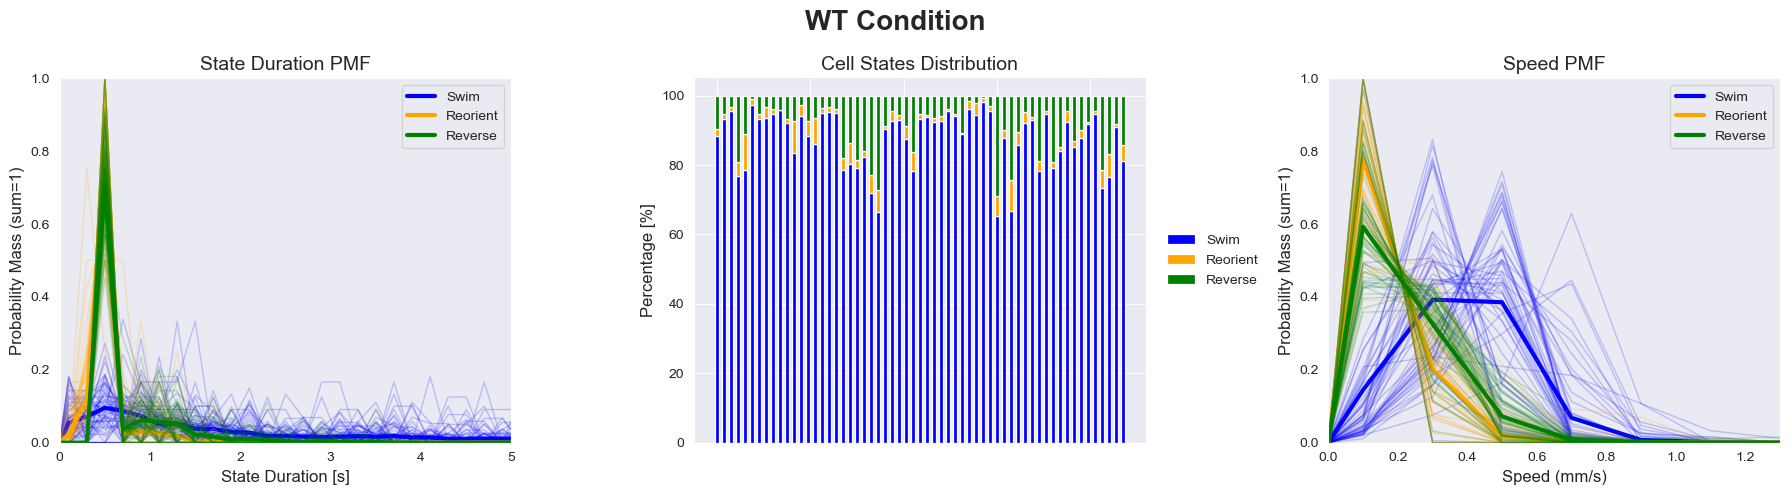

In [7]:
input_folder = 'CONDITION_wt'
csv_files = glob.glob(os.path.join(input_folder, 'STATES_*states_timeseries.csv'))
state_labels = ['Swim', 'Reorient', 'Reverse']
state_indices = {label: idx for idx, label in enumerate(state_labels)}
speed_col = 'velocity'
state_col = 'state'
time_col = 'time_sec'
colors = {'Swim': 'blue', 'Reorient': 'orange', 'Reverse': 'green'}

# Prepare containers for per-cell data
cell_speeds = {label: [] for label in state_labels}
cell_durations = {label: [] for label in state_labels}
percentages_list = []

for file in csv_files:
    df = pd.read_csv(file)
    # Per-cell speeds
    for label in state_labels:
        idx = state_indices[label]
        speeds = df.loc[df[state_col] == idx, speed_col].values
        speeds = speeds[np.isfinite(speeds)]
        cell_speeds[label].append(speeds)
    # Per-cell durations
    state_changes = df[state_col].ne(df[state_col].shift()).cumsum()
    grouped = df.groupby(state_changes)
    durations_per_state = {label: [] for label in state_labels}
    for _, group in grouped:
        state_val = group[state_col].iloc[0]
        if state_val in state_indices.values():
            for label in state_labels:
                if state_indices[label] == state_val:
                    durations_per_state[label].append(len(group) * (df[time_col].iloc[1] - df[time_col].iloc[0]) if len(group) > 1 else 0)
    for label in state_labels:
        # Remove zero durations (from single-frame states)
        durations = [d for d in durations_per_state[label] if d > 0]
        cell_durations[label].append(durations)
    # Percentages
    percent = {}
    for label in state_labels:
        percent[label] = 100 * np.sum(df[state_col] == state_indices[label]) / len(df)
    percent['Cell'] = os.path.basename(file)
    percentages_list.append(percent)

percentages = pd.DataFrame(percentages_list)

# PMF bin settings
duration_bin_size = 0.2
speed_bin_size = 0.2
duration_bins = np.arange(0, 10.1 + duration_bin_size, duration_bin_size)
speed_bins = np.arange(0, 1.51 + speed_bin_size, speed_bin_size)
duration_bin_centers = (duration_bins[:-1] + duration_bins[1:]) / 2
speed_bin_centers = (speed_bins[:-1] + speed_bins[1:]) / 2

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Subplot 1: State duration PMF (lines start at 0)
ax = axes[0]
for label in state_labels:
    # Faint PMF for each cell
    for durations in cell_durations[label]:
        durations = np.array(durations)
        durations = durations[np.isfinite(durations)]
        if len(durations) > 0:
            pmf, _ = np.histogram(durations, bins=duration_bins, density=False)
            pmf = pmf / pmf.sum() if pmf.sum() > 0 else pmf
            # Prepend 0 at x=0
            x = np.concatenate([[0], duration_bin_centers])
            y = np.concatenate([[0], pmf])
            ax.plot(x, y, color=colors[label], alpha=0.2, linewidth=1)
    # Bold average PMF
    all_durations = np.concatenate([np.array(d) for d in cell_durations[label] if len(d) > 0])
    all_durations = all_durations[np.isfinite(all_durations)]
    if len(all_durations) > 0:
        avg_pmf, _ = np.histogram(all_durations, bins=duration_bins, density=False)
        avg_pmf = avg_pmf / avg_pmf.sum() if avg_pmf.sum() > 0 else avg_pmf
        x = np.concatenate([[0], duration_bin_centers])
        y = np.concatenate([[0], avg_pmf])
        ax.plot(x, y, color=colors[label], linewidth=3, label=label)
ax.set_xlim(0, 5)
ax.set_ylim(0, 1)
ax.set_xlabel("State Duration [s]", fontsize=12)
ax.set_ylabel("Probability Mass (sum=1)", fontsize=12)
ax.set_title("State Duration PMF", fontsize=14)
ax.grid(False)
ax.legend()

# Subplot 2: Stacked bar plot of state percentages per cell
ax = axes[1]
bar_width = 0.1
x = np.arange(len(percentages)) * 0.15
bottom = np.zeros(len(percentages), dtype=float)
for label in state_labels:
    values = percentages[label].values
    ax.bar(x, values, bottom=bottom, width=bar_width, label=label, color=colors[label], edgecolor='white', linewidth=0.9)
    bottom += values
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.set_ylabel('Percentage [%]', fontsize=12)
ax.set_title('Cell States Distribution', fontsize=14)
ax.legend(fontsize=10, frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5))
sns.despine(ax=ax)

# Subplot 3: Speed PMF (lines start at 0)
ax = axes[2]
for label in state_labels:
    # Faint PMF for each cell
    for speeds in cell_speeds[label]:
        speeds = np.array(speeds)
        speeds = speeds[np.isfinite(speeds)]
        if len(speeds) > 0:
            pmf, _ = np.histogram(speeds, bins=speed_bins, density=False)
            pmf = pmf / pmf.sum() if pmf.sum() > 0 else pmf
            x = np.concatenate([[0], speed_bin_centers])
            y = np.concatenate([[0], pmf])
            ax.plot(x, y, color=colors[label], alpha=0.2, linewidth=1)
    # Bold average PMF
    all_speeds = np.concatenate([np.array(s) for s in cell_speeds[label] if len(s) > 0])
    all_speeds = all_speeds[np.isfinite(all_speeds)]
    if len(all_speeds) > 0:
        avg_pmf, _ = np.histogram(all_speeds, bins=speed_bins, density=False)
        avg_pmf = avg_pmf / avg_pmf.sum() if avg_pmf.sum() > 0 else avg_pmf
        x = np.concatenate([[0], speed_bin_centers])
        y = np.concatenate([[0], avg_pmf])
        ax.plot(x, y, color=colors[label], linewidth=3, label=label)
ax.set_xlim(0, 1.3)
ax.set_ylim(0, 1)
ax.set_xlabel("Speed (mm/s)", fontsize=12)
ax.set_ylabel("Probability Mass (sum=1)", fontsize=12)
ax.set_title("Speed PMF", fontsize=14)
ax.grid(False)
ax.legend()

plt.suptitle('WT Condition', fontsize=20, weight='bold')
plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.savefig('Analysis_WT_pmfplots_start0.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig('Analysis_WT_pmfplots_start0.png', dpi=300, bbox_inches='tight')
plt.show()

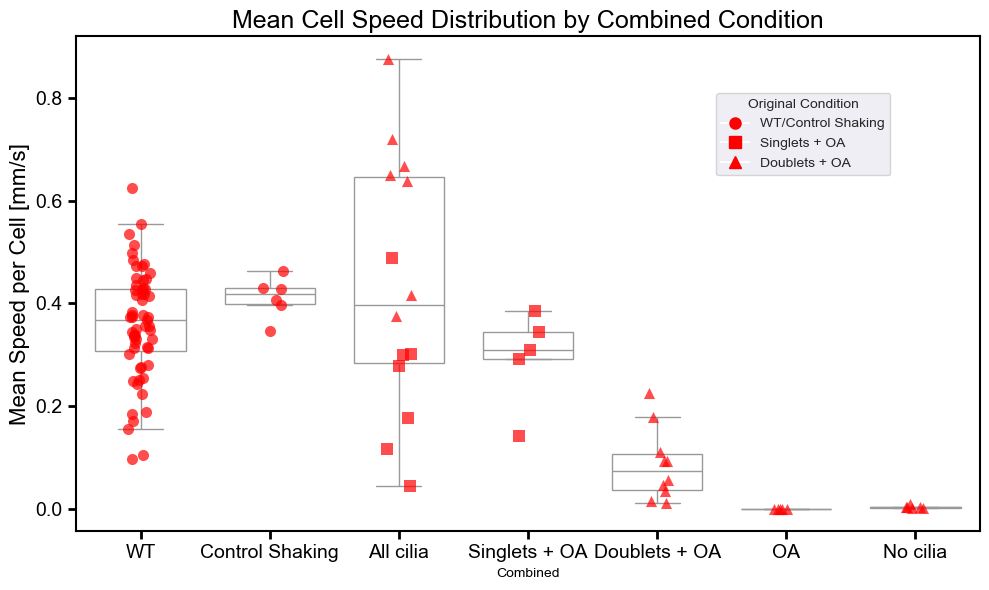

In [8]:
# 1. Gather all mean speeds per cell for each condition
condition_folders = glob.glob("CONDITION_*")
state_labels = ['Swim', 'Reorient', 'Reverse']
state_col = 'state'
time_col = 'time_sec'

# Assign marker per original condition
condition_markers = {
    'CONDITION_wt': 'o',
    'CONDITION_controlshaking': 'o',
    'CONDITION_allEtoh': '^',
    'CONDITION_allSucrose': 's',
    'CONDITION_singlets': 's',
    'CONDITION_doublets': '^',
    'CONDITION_mouth': '^',
    'CONDITION_nocilia': '^',
}

# Define combined boxes: key = label on x-axis, value = list of condition folder names
combined_conditions = {
    'WT': ['CONDITION_wt'],
    'Control Shaking': ['CONDITION_controlshaking'],
    'All cilia': ['CONDITION_allEtoh', 'CONDITION_allSucrose'],
    'Singlets + OA': ['CONDITION_singlets'],
    'Doublets + OA': ['CONDITION_doublets'],
    'OA': ['CONDITION_mouth'],
    'No cilia': ['CONDITION_nocilia'],
}
combined_order = list(combined_conditions.keys())

# 2. Build long-form DataFrame: each row = mean speed, original condition, marker, combined box
plot_data = []
for box_name, conds in combined_conditions.items():
    for cond in conds:
        csv_files = glob.glob(os.path.join(cond, "*states_timeseries.csv"))
        for csv_file in csv_files:
            df = pd.read_csv(csv_file)
            if 'velocity' in df.columns:
                mean_speed = df['velocity'].mean()
                plot_data.append({
                    'Combined': box_name,
                    'Condition': cond,
                    'MeanSpeed': mean_speed,
                    'Marker': condition_markers.get(cond, 'o')
                })

plot_df = pd.DataFrame(plot_data)
plot_df['Combined'] = pd.Categorical(plot_df['Combined'], categories=combined_order, ordered=True)

# 3. Plot: single boxplot + stripplot, one box per combined group, marker by condition
plt.figure(figsize=(10, 6))
ax = plt.gca()
sns.boxplot(
    x='Combined', y='MeanSpeed', data=plot_df,
    order=combined_order, color='white', width=0.7, linewidth=1, showfliers=False, ax=ax
)

# Overlay stripplot: plot each condition separately for marker control
for cond, marker in condition_markers.items():
    subset = plot_df[plot_df['Condition'] == cond]
    if not subset.empty:
        sns.stripplot(
            x='Combined', y='MeanSpeed', data=subset,
            order=combined_order, marker=marker, color='red', size=8, jitter=True, alpha=0.7, ax=ax
        )

# Style: white background, black axes/ticks, no grid, show tick marks
ax.set_facecolor('white')
ax.grid(False)
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.5)
ax.tick_params(axis='x', which='both', direction='out', length=6, width=2, colors='black', bottom=True, left=True, top=False, right=False)
ax.tick_params(axis='y', which='both', direction='out', length=6, width=2, colors='black', bottom=True, left=True, top=False, right=False)
ax.yaxis.label.set_color('black')
ax.xaxis.label.set_color('black')

plt.ylabel("Mean Speed per Cell [mm/s]", fontsize=16, color='black')
plt.title("Mean Cell Speed Distribution by Combined Condition", fontsize=18, color='black')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Custom legend for markers
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='WT/Control Shaking', markerfacecolor='red', markersize=8, markeredgecolor='red'),
    Line2D([0], [0], marker='s', color='w', label='Singlets + OA', markerfacecolor='red', markersize=8, markeredgecolor='red'),
    Line2D([0], [0], marker='^', color='w', label='Doublets + OA', markerfacecolor='red', markersize=8, markeredgecolor='red'),
]
plt.legend(handles=legend_elements, title='Original Condition', bbox_to_anchor=(0.7, 0.9), loc='upper left')

plt.tight_layout()
plt.savefig('mean_speed_per_cell_combined_boxplot.svg', format='svg', bbox_inches='tight')
plt.savefig('mean_speed_per_cell_combined_boxplot.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# # same plot for feeding experiments - ratio intensity
#
# # Style
# mpl.rcParams['svg.fonttype'] = 'none'
# mpl.rcParams['font.family'] = 'Arial'
# plt.style.use('default')
#
# # --- Data loading and preparation ---
# folder = "W:\\Users\\Daphne\\WT_RESULTS\\WT_feeding\\"
# csv_files = glob.glob(os.path.join(folder, "*.csv"))
# data_dict = {}
# for file in csv_files:
#     condition_name = os.path.splitext(os.path.basename(file))[0]
#     df = pd.read_csv(file)
#     if "Ratio intensity" in df.columns:
#         data_dict[condition_name] = df["Ratio intensity"].dropna()
#     else:
#         print(f"Warning: 'Ratio intensity' not found in {file}")
# data_dict = dict(sorted(data_dict.items()))
#
# condition_markers_raw = {
#     '1_feeding_ciliated_cells': 'o',   # control
#     '1_feeding_ciliated_cells_controlshaking': 'o',   # control
#     '2_feeding_fully_ciliated_cells_deciliationexp_sucrose': 's',  # sucrose
#     '3_feeding_partly_ciliated_cells_singlets': 's',               # sucrose
#     '4_feeding_fully_ciliated_cells_deciliationexp': '^',          # EtOH
#     '4_feeding_partly_ciliated_cells_doublets': '^',               # EtOH
#     '6_feeding_deciliated_cells_ciliainmouth': '^',                # EtOH
#     '7_feeding_fully_deciliated_cells': '^',                       # EtOH
# }
#
# combined_conditions = {
#     'Control': ['1_feeding_ciliated_cells'],
#     'Control shaking': ['1_feeding_ciliated_cells_controlshaking'],
#     'All cilia': ['4_feeding_fully_ciliated_cells_deciliationexp', '2_feeding_fully_ciliated_cells_deciliationexp_sucrose'],
#     'Singlets+OA': ['3_feeding_partly_ciliated_cells_singlets'],
#     'Doublets+OA': ['4_feeding_partly_ciliated_cells_doublets'],
#     'Only OA': ['6_feeding_deciliated_cells_ciliainmouth'],
#     'No cilia': ['7_feeding_fully_deciliated_cells'],
# }
#
# plot_data = []
# for box_name, conds in combined_conditions.items():
#     valid_conds = [c for c in conds if c in data_dict]
#     for cond in valid_conds:
#         marker = condition_markers_raw.get(cond, 'o')
#         for v in data_dict[cond]:
#             plot_data.append({
#                 'Combined': box_name,
#                 'Original': cond,
#                 'Value': v,
#                 'Marker': marker
#             })
# plot_df = pd.DataFrame(plot_data)
#
# # --- Plotting ---
# plt.figure(figsize=(10, 6))
# ax = plt.gca()
# sns.boxplot(x='Combined', y='Value', data=plot_df, color='white', width=0.5, showfliers=False, ax=ax)
#
# # Overlay stripplot: plot each original condition separately, so markers can differ within a box
# for box_name, conds in combined_conditions.items():
#     for cond in conds:
#         marker = condition_markers_raw.get(cond, 'o')
#         subset = plot_df[(plot_df['Combined'] == box_name) & (plot_df['Original'] == cond)]
#         if not subset.empty:
#             sns.stripplot(
#                 x='Combined', y='Value', data=subset,
#                 marker=marker, color='red', size=8, jitter=True, alpha=0.7, ax=ax
#             )
#
# # Style: white background, black axes/ticks, no grid, show tick marks
# ax.set_facecolor('white')
# ax.grid(False)
# for spine in ['top', 'right', 'left', 'bottom']:
#     ax.spines[spine].set_color('black')
#     ax.spines[spine].set_linewidth(1.2)
# ax.tick_params(axis='both', which='both', direction='out', length=6, width=1.2, colors='black', bottom=True, left=True, top=False, right=False)
# ax.yaxis.label.set_color('black')
# ax.xaxis.label.set_color('black')
#
# # Add custom legend for markers
# legend_elements = [
#     Line2D([0], [0], marker='o', color='w', label='Control', markerfacecolor='red', markersize=8, markeredgecolor='red'),
#     Line2D([0], [0], marker='s', color='w', label='Sucrose', markerfacecolor='red', markersize=8, markeredgecolor='red'),
#     Line2D([0], [0], marker='^', color='w', label='EtOH', markerfacecolor='red', markersize=8, markeredgecolor='red'),
# ]
# plt.legend(handles=legend_elements, title='Original Condition', bbox_to_anchor=(0.8, 0.95), loc='upper left')
#
# plt.ylabel("Ratio intensity", fontsize=16, color='black')
# plt.title("Ratio Intensity by Condition", fontsize=18, color='black')
# plt.tight_layout()
# plt.savefig(os.path.join(folder, "ratio_intensity_boxplot_combined.svg"), format="svg", bbox_inches="tight")
# plt.savefig(os.path.join(folder, "ratio_intensity_boxplot_combined.png"), format="png", dpi=300, bbox_inches="tight")
# plt.show()

C:\Users\laan\AppData\Local\Temp\ipykernel_118960\2768847265.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='State', y='MeanDuration', data=mean_df, order=desired_order, palette='Set2', linewidth=1.5, ax=ax)


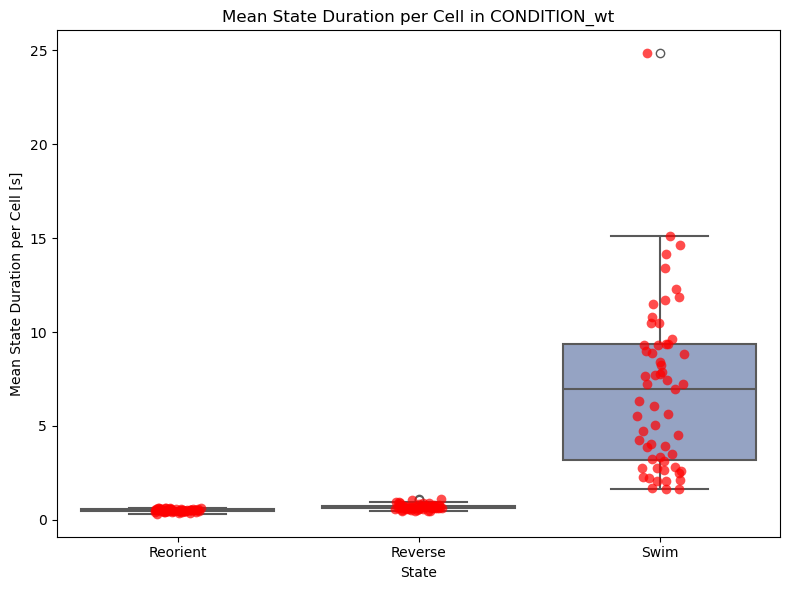

Reorient: mean = 0.5036 s, std = 0.0698 s
Reverse: mean = 0.6923 s, std = 0.1345 s
Swim: mean = 6.9547 s, std = 4.4346 s


In [11]:
condition_folder = 'CONDITION_wt'
csv_files = glob.glob(os.path.join(condition_folder, 'STATES_*states_timeseries.csv'))
state_labels = ['Swim', 'Reorient', 'Reverse']
desired_order = ['Reorient', 'Reverse', 'Swim']

# Mapping from excel state_label to analysis state
state_map = {'Swim': 'Swim', 'Steer': 'Reorient', 'Turn': 'Reverse'}

mean_durations = []
for file in csv_files:
    df = pd.read_csv(file)
    if 'state_label' not in df.columns or 'time_sec' not in df.columns:
        continue
    # Map state_label to analysis state
    df['State'] = df['state_label'].map(state_map)
    for state in state_labels:
        # Find all contiguous groups of this state
        mask = df['State'] == state
        if not mask.any():
            continue
        # Group by contiguous blocks
        durations = []
        group = None
        for idx, is_state in enumerate(mask):
            if is_state:
                if group is None:
                    group = [idx]
                else:
                    group.append(idx)
            else:
                if group is not None:
                    # Compute duration for this group
                    t0 = df.iloc[group[0]]['time_sec']
                    t1 = df.iloc[group[-1]]['time_sec']
                    durations.append(t1 - t0)
                    group = None
        if group is not None:
            t0 = df.iloc[group[0]]['time_sec']
            t1 = df.iloc[group[-1]]['time_sec']
            durations.append(t1 - t0)
        # Store mean duration for this cell and state
        if len(durations) > 0:
            mean_durations.append({'Cell': os.path.basename(file), 'State': state, 'MeanDuration': np.mean(durations)})

mean_df = pd.DataFrame(mean_durations)
mean_df['State'] = pd.Categorical(mean_df['State'], categories=desired_order, ordered=True)

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
ax.set_facecolor('white')

sns.boxplot(x='State', y='MeanDuration', data=mean_df, order=desired_order, palette='Set2', linewidth=1.5, ax=ax)
sns.stripplot(x='State', y='MeanDuration', data=mean_df, order=desired_order, color='red', size=7, jitter=True, alpha=0.7, ax=ax)

plt.ylabel('Mean State Duration per Cell [s]')
plt.title('Mean State Duration per Cell in CONDITION_wt')
plt.grid(False)
plt.tight_layout()
plt.savefig('mean_state_duration_per_cell_condition_wt_box_strip.svg', format='svg', facecolor='white', dpi=300)
plt.show()

# Compute mean and std for each state
results = {}
for state in desired_order:
    durations = mean_df.loc[mean_df['State'] == state, 'MeanDuration']
    mean_val = durations.mean()
    std_val = durations.std()
    results[state] = {'mean': mean_val, 'std': std_val}

for state in desired_order:
    print(f"{state}: mean = {results[state]['mean']:.4f} s, std = {results[state]['std']:.4f} s")

C:\Users\laan\AppData\Local\Temp\ipykernel_118960\2456460212.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='State', y='MeanSpeed', data=mean_df, order=desired_order, palette='Set2', linewidth=1.5, ax=ax)


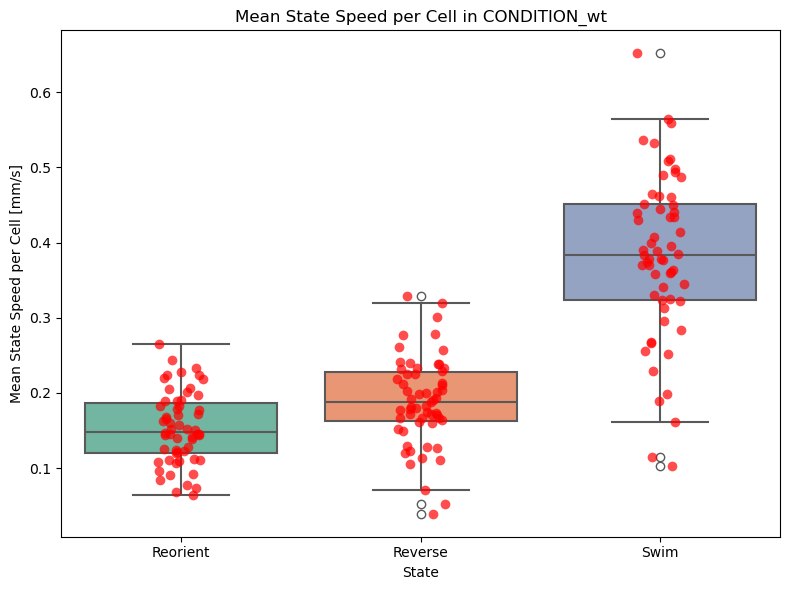

Reorient: mean = 0.1535, std = 0.0477
Reverse: mean = 0.1890, std = 0.0589
Swim: mean = 0.3815, std = 0.1103


In [12]:
condition_folder = 'CONDITION_wt'
csv_files = glob.glob(os.path.join(condition_folder, 'STATES_*states_timeseries.csv'))
state_labels = ['Swim', 'Reorient', 'Reverse']
desired_order = ['Reorient', 'Reverse', 'Swim']
state_map = {'Swim': 'Swim', 'Steer': 'Reorient', 'Turn': 'Reverse'}

mean_speeds = []
for file in csv_files:
    df = pd.read_csv(file)
    # Map state_label to analysis state
    if 'state_label' in df.columns:
        df['State'] = df['state_label'].map(state_map)
    else:
        continue  # skip if no state_label column
    for state in state_labels:
        state_df = df[df['State'] == state]
        if not state_df.empty and 'velocity' in state_df.columns:
            mean_speed = state_df['velocity'].mean()
            mean_speeds.append({
                'Cell': os.path.basename(file),
                'State': state,
                'MeanSpeed': mean_speed
            })

mean_df = pd.DataFrame(mean_speeds)
mean_df['State'] = pd.Categorical(mean_df['State'], categories=desired_order, ordered=True)

plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
ax.set_facecolor('white')

sns.boxplot(x='State', y='MeanSpeed', data=mean_df, order=desired_order, palette='Set2', linewidth=1.5, ax=ax)
sns.stripplot(x='State', y='MeanSpeed', data=mean_df, order=desired_order, color='red', size=7, jitter=True, alpha=0.7, ax=ax)

plt.ylabel('Mean State Speed per Cell [mm/s]')
plt.title('Mean State Speed per Cell in CONDITION_wt')
plt.grid(False)
plt.tight_layout()
plt.savefig('mean_state_speed_per_cell_condition_wt_box_strip.svg', format='svg', facecolor='white', dpi=300)
plt.show()

# Compute mean and std for each state
results = {}
for state in desired_order:
    speeds = mean_df.loc[mean_df['State'] == state, 'MeanSpeed']
    mean_val = speeds.mean()
    std_val = speeds.std()
    results[state] = {'mean': mean_val, 'std': std_val}

for state in desired_order:
    print(f"{state}: mean = {results[state]['mean']:.4f}, std = {results[state]['std']:.4f}")

C:\Users\laan\AppData\Local\Temp\ipykernel_118960\2400235423.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="State", y="Duration", data=dur_df, order=desired_order, inner="box", palette="Set2", linewidth=1.5, ax=ax)


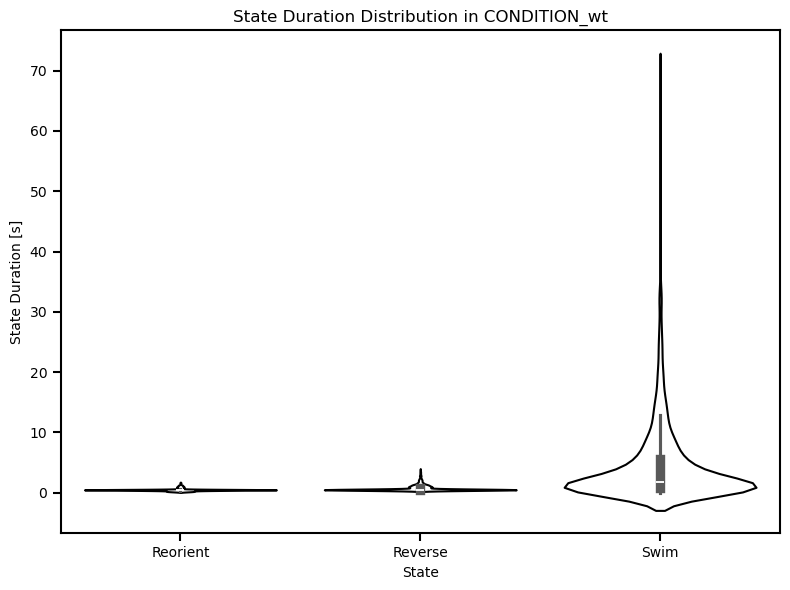

In [10]:
# Step 1: List CSV files in CONDITION_wt
condition_folder = "CONDITION_wt"
csv_files = glob.glob(os.path.join(condition_folder, "STATES_*states_timeseries.csv"))

# Step 2: Define state labels and desired order
state_labels = ["Swim", "Reorient", "Reverse"]
desired_order = ["Reorient", "Reverse", "Swim"]

# Step 3: Collect durations for each state
durations = []
for file in csv_files:
    df = pd.read_csv(file)
    state_changes = df["state"].ne(df["state"].shift()).cumsum()
    grouped = df.groupby(state_changes)
    for _, group in grouped:
        state_idx = int(group["state"].iloc[0])
        if state_idx < len(state_labels):
            label = state_labels[state_idx]
            duration = group["time_sec"].iloc[-1] - group["time_sec"].iloc[0]
            durations.append({"State": label, "Duration": duration})

# Step 4: Create DataFrame and set categorical order
dur_df = pd.DataFrame(durations)
dur_df["State"] = pd.Categorical(dur_df["State"], categories=desired_order, ordered=True)

# Step 5: Plot violin plot with custom order
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
ax.set_facecolor('white')

sns.violinplot(x="State", y="Duration", data=dur_df, order=desired_order, inner="box", palette="Set2", linewidth=1.5, ax=ax)

for violin in ax.collections:
    violin.set_facecolor('white')
    violin.set_edgecolor('black')
    violin.set_linewidth(1.5)

for spine in ['left', 'bottom', 'top', 'right']:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.5)
    ax.spines[spine].set_visible(True)

ax.tick_params(axis='x', which='both', color='black', direction='out', length=6, width=1.5, bottom=True)
ax.tick_params(axis='y', which='both', color='black', direction='out', length=6, width=1.5, left=True)

plt.ylabel("State Duration [s]")
plt.title("State Duration Distribution in CONDITION_wt")
plt.grid(False)
# plt.ylim(-1, 15)
plt.tight_layout()
plt.savefig('state_duration_distribution_condition_wt.svg', format='svg', facecolor='white', dpi=300)
plt.show()

C:\Users\laan\AppData\Local\Temp\ipykernel_118960\3613310101.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="State", y="Speed", data=speed_df, order=desired_order, inner="box", palette="Set2", linewidth=1.5, ax=ax)


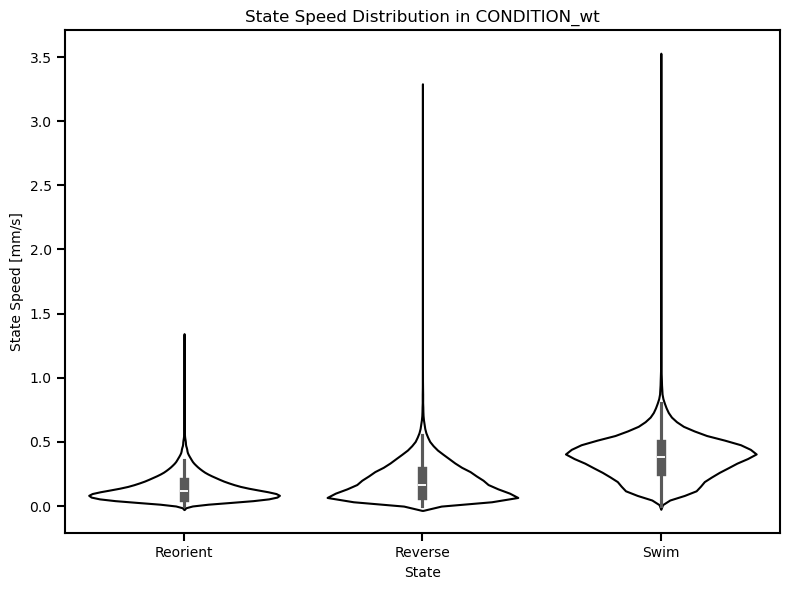

In [13]:
# Step 1: List CSV files in CONDITION_wt
condition_folder = "CONDITION_wt"
csv_files = glob.glob(os.path.join(condition_folder, "STATES_*states_timeseries.csv"))

# Step 2: Define state labels and desired order
state_labels = ["Swim", "Reorient", "Reverse"]
desired_order = ["Reorient", "Reverse", "Swim"]

# Step 3: Collect speeds for each state
speeds = []
for file in csv_files:
    df = pd.read_csv(file)
    state_changes = df["state"].ne(df["state"].shift()).cumsum()
    grouped = df.groupby(state_changes)
    for _, group in grouped:
        state_idx = int(group["state"].iloc[0])
        if state_idx < len(state_labels):
            label = state_labels[state_idx]
            # Collect all speed values for this state segment
            for speed_value in group["velocity"]:
                speeds.append({"State": label, "Speed": speed_value})

# Step 4: Create DataFrame and set categorical order
speed_df = pd.DataFrame(speeds)
speed_df["State"] = pd.Categorical(speed_df["State"], categories=desired_order, ordered=True)

# Step 5: Plot violin plot with custom order
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
ax.set_facecolor('white')

sns.violinplot(x="State", y="Speed", data=speed_df, order=desired_order, inner="box", palette="Set2", linewidth=1.5, ax=ax)

for violin in ax.collections:
    violin.set_facecolor('white')
    violin.set_edgecolor('black')
    violin.set_linewidth(1.5)

for spine in ['left', 'bottom', 'top', 'right']:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1.5)
    ax.spines[spine].set_visible(True)

ax.tick_params(axis='x', which='both', color='black', direction='out', length=6, width=1.5, bottom=True)
ax.tick_params(axis='y', which='both', color='black', direction='out', length=6, width=1.5, left=True)

plt.ylabel("State Speed [mm/s]")
plt.title("State Speed Distribution in CONDITION_wt")
plt.grid(False)
plt.tight_layout()
plt.savefig('state_speed_distribution_condition_wt.svg', format='svg', facecolor='white', dpi=300)
plt.show()

Markov chain analysis functions

In [40]:
def transition_matrix(A):  # all transitions, including self-transitions
    A = np.array(A, dtype=float) # Convert input to float numpy array for division
    row_sums = A.sum(axis=1, keepdims=True) # Compute the sum of each row (for normalization)
    with np.errstate(divide='ignore', invalid='ignore'):  # avoid warnings for zero rows
        prob_matrix = np.divide(A, row_sums, where=row_sums != 0) # divide each row by its sum to get transition probabilities
    rows_with_zero = (row_sums == 0).flatten() # For rows where the sum is zero (no transitions), set the row to zero
    prob_matrix[rows_with_zero, :] = 0
    return prob_matrix

def transition_matrix_exclude_self(A): # only transitions between different states
    A = np.array(A, dtype=float)
    for i in range(A.shape[0]):
        A[i, i] = 0 # Set diagonal to zero to ignore self-transitions
    row_sums = A.sum(axis=1, keepdims=True) # Compute the sum of each row (for normalization)
    with np.errstate(divide='ignore', invalid='ignore'):
        prob_matrix = np.divide(A, row_sums, where=row_sums != 0)
    rows_with_zero = (row_sums == 0).flatten()
    prob_matrix[rows_with_zero, :] = 0
    return prob_matrix

def analyse_files(csv_files, state_labels, time_col="time_sec"):
    percentages = [] # List to store the percentage of time each cell spends in each state
    duration_state = {label: [] for label in state_labels} # Dictionary to store durations for each state label
    speed_state = {label: [] for label in state_labels} # Dictionary to store speed values for each state label
    M = np.zeros((3, 3), dtype=int) # Global transition count matrix (all files combined)
    N = np.zeros((len(csv_files), 3, 3), dtype=int) # Per-file transition count matrices (for standard deviation calculation)
    transition_N = np.zeros((len(csv_files), 3, 3), dtype=float) # Per-file transition probability matrices
    # Lists to store per-cell time series
    speed = []
    ang_velocity = []
    state_timeseries = []
    for idx, file in enumerate(csv_files):
        df = pd.read_csv(file)
        cell = os.path.basename(file).replace("_states_timeseries.csv", "") # Extract cell name from file name
        # Store velocity, angular velocity, and state time series
        speed.append(df["velocity"])
        ang_velocity.append(df["ang_velocity"])
        state_timeseries.append(df["state"])

        # Store speed values for each state
        for i in range(len(df["velocity"])):
            st_idx = int(df["state"].iloc[i])  # state index (0, 1, 2) at position i
            label = state_labels[st_idx]       # map index to state label
            speed_state[label].append(df["velocity"].iloc[i])

        # Calculate percentage of time spent in each state for this cell
        counts = df["state"].value_counts(normalize=True).reindex([0, 1, 2], fill_value=0) * 100
        percent = {"Cell": cell}
        for i, label in enumerate(state_labels):
            percent[label] = counts.get(i, 0.0)  # get percentage for each state, 0 if missing

        percentages.append(percent)

        # Build transition count matrices for this cell and globally
        states = df["state"].tolist()
        for k in range(len(states) - 1):
            M[states[k], states[k + 1]] += 1
            N[idx, states[k], states[k + 1]] += 1

        transition_N[idx] = transition_matrix(N[idx]) # Compute transition probability matrix for this cell

        # Compute durations for each contiguous block of the same state
        state_changes = df["state"].ne(df["state"].shift()).cumsum()
        grouped = df.groupby(state_changes)
        for _, group in grouped:
            state = group["state"].iloc[0]
            duration = group[time_col].iloc[-1] - group[time_col].iloc[0]  # duration of this state block
            duration_state[state_labels[state]].append(duration)

    print("Count of transitions: ", M)

    # Compute global transition probability matrix and standard deviation across cells
    transition_M = transition_matrix(M)
    squared_diff_sum = np.zeros((3, 3), dtype=float)
    for a in range(len(csv_files)):
        for k in range(3):
            for l in range(3):
                squared_diff_sum[k, l] += (transition_N[a, k, l] - transition_M[k, l]) ** 2
    standard_dev = np.sqrt(squared_diff_sum / len(csv_files))

    # DataFrame of state percentages per cell
    df_percent = pd.DataFrame(percentages)
    cols = ["Cell"] + state_labels
    df_percent = df_percent[cols]

    return df_percent, duration_state, transition_M, standard_dev, speed, ang_velocity, state_timeseries, speed_state

In [41]:
csv_files = glob.glob( "W:\\Users\\Daphne\\Analysis\\Daphne_Paramecium_paper\\Cell swimming analysis\\CONDITION_wt\\STATES_*states_timeseries.csv")
states= ["swim", "reorient", "reverse"]
percentages, durations, transition_M, std, speed, ang_velocity, state_timeseries, speed_state= analyse_files(csv_files, states)
print("transition matrix including self transitions: ", transition_M)
print("std: ", std)
matrix_norm=transition_matrix_exclude_self(M)
print("transition matrix: ", matrix_norm)

Count of transitions:  [[377157    743   1903]
 [   743  11348      0]
 [  1905      0  42076]]
transition matrix including self transitions:  [[0.99303323 0.00195628 0.00501049]
 [0.06145067 0.93854933 0.        ]
 [0.04331416 0.         0.95668584]]
std:  [[0.00506879 0.00191089 0.00374185]
 [0.01182499 0.12249861 0.        ]
 [0.00923624 0.         0.00923624]]
transition matrix:  [[0.         0.28080121 0.71919879]
 [1.         0.         0.        ]
 [1.         0.         0.        ]]


In [42]:
state_columns = [col for col in percentages.columns if col.lower() in ['swim', 'reorient', 'reverse']]
print("Mean percentage and standard deviation of each state across all cells:")
for state in state_columns:
    mean_pct = percentages[state].mean()
    std_pct = percentages[state].std()
    print(f"{state}: mean = {mean_pct:.2f}%, std = {std_pct:.2f}%")

Mean percentage and standard deviation of each state across all cells:
swim: mean = 87.71%, std = 8.41%
reorient: mean = 2.81%, std = 2.33%
reverse: mean = 9.48%, std = 6.96%
